#### ARIMA Time Series Analysis: Apple Stock Price Forecasting

In [1]:
#Import libraries
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")

In [2]:
#Read the csv 
df = pd.read_csv("AAPL_historical_data.csv")
df.head()

,Date,Open,High,Low,Close
0,1980-12-12 00:00:00-05:00,0.098834,0.099264,0.098834,0.098834
1,1980-12-15 00:00:00-05:00,0.094108,0.094108,0.093678,0.093678
2,1980-12-16 00:00:00-05:00,0.087232,0.087232,0.086802,0.086802
3,1980-12-17 00:00:00-05:00,0.088951,0.089381,0.088951,0.088951
4,1980-12-18 00:00:00-05:00,0.091530,0.091959,0.091530,0.091530


##### 1. Preparing data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    11094 non-null  object 
 1   Open    11094 non-null  float64
 2   High    11094 non-null  float64
 3   Low     11094 non-null  float64
 4   Close   11094 non-null  float64
dtypes: float64(4), object(1)
memory usage: 433.5+ KB


In [4]:
# drop "Open", "High" and "Low" columns because they are not neccessary for ARIMA modelling
df = df.drop(columns=["Open", "High", "Low"])
df.head()


,Date,Close
0,1980-12-12 00:00:00-05:00,0.098834
1,1980-12-15 00:00:00-05:00,0.093678
2,1980-12-16 00:00:00-05:00,0.086802
3,1980-12-17 00:00:00-05:00,0.088951
4,1980-12-18 00:00:00-05:00,0.091530


In [5]:
#convert the date to datetime format and set it as the index
df.index = pd.to_datetime(df["Date"])
df = df.drop('Date', axis=1)
df.head()


,Close
Date,
1980-12-12 00:00:00-05:00,0.098834
1980-12-15 00:00:00-05:00,0.093678
1980-12-16 00:00:00-05:00,0.086802
1980-12-17 00:00:00-05:00,0.088951
1980-12-18 00:00:00-05:00,0.091530


In [6]:
"""""
Stock prices can have outliers. Common causes include:

Stock splits
Errors in data recording
Flash crashes
Major company events/news
"""""
#Remove outliers
# Z-score method
z_score = (df['Close'] - df['Close'].mean()) / df['Close'].std()
df = df[abs(z_score) <= 3]


##### 2. Exploring Data

In [7]:
# Determining the "d" in the order p, d, q
# For d parameter
result = adfuller(df['Close'])
d = 1 if result[1] > 0.05 else 0
print(d)



1


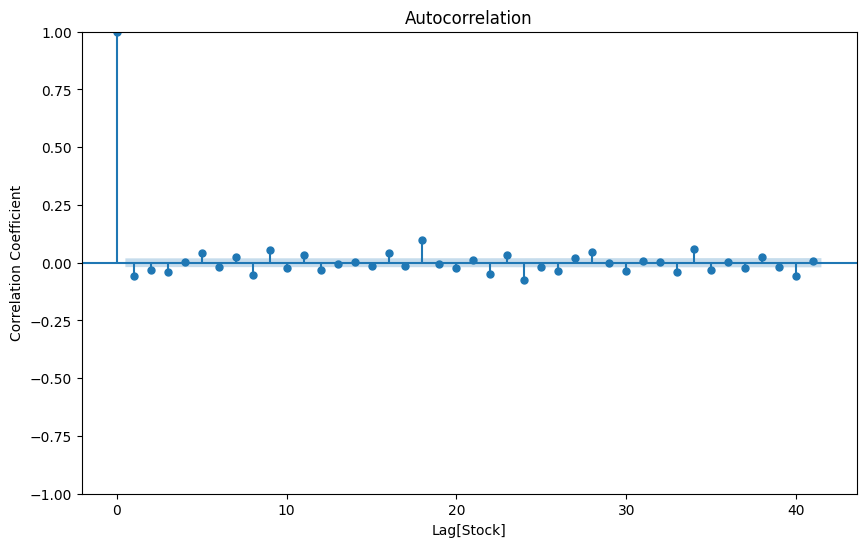

In [8]:
#Create an ACF plot for data in df
fig, ax=plt.subplots(figsize = (10,6))
plot_acf(df["Close"].diff().dropna(), ax=ax)
plt.xlabel("Lag[Stock]")
plt.ylabel("Correlation Coefficient");

In [9]:
"""Looking at the pattern of the above acf plot, the possible q is 1, there is only significant autocorrelation at first lag"""


'Looking at the pattern of the above acf plot, the possible q is 1, there is only significant autocorrelation at first lag'

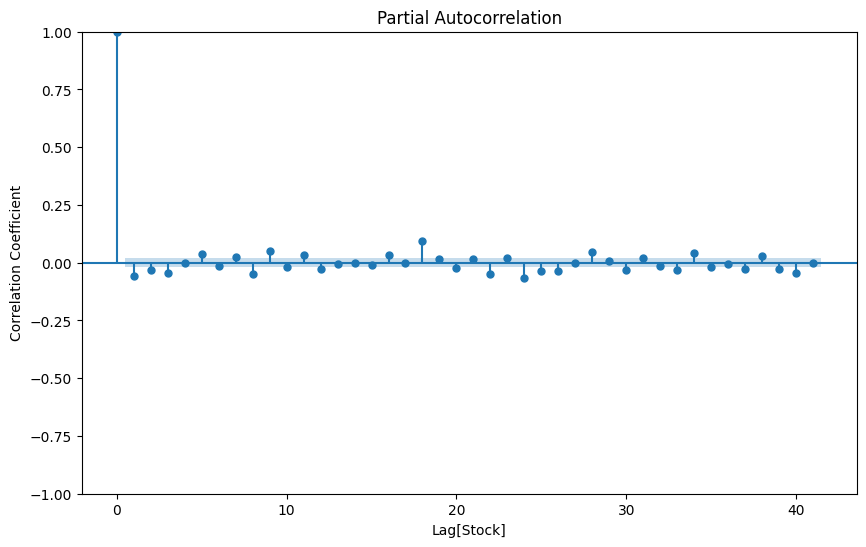

In [10]:
#Create a pacf plot
fig, ax=plt.subplots(figsize = (10,6))
plot_pacf(df["Close"].diff().dropna(), ax=ax)
plt.xlabel("Lag[Stock]")
plt.ylabel("Correlation Coefficient");

In [11]:
"""Based on the pacf plot above p is also 1"""

'Based on the pacf plot above p is also 1'

#### 3. Splitting the data

In [12]:
# Create a training set y_train that is 90% of the data and 10% for the y_test set
cut_off = int(len(df) *0.9)
y_train = df[:cut_off]
y_test = df[cut_off:]
# Verify the split
print('Training set size:', len(y_train))
print('Test set size:', len(y_test))
print('\nTraining set date range:', y_train.index[0], 'to', y_train.index[-1])
print('Test set date range:', y_test.index[0], 'to', y_test.index[-1])

Training set size: 9622
Test set size: 1070

Training set date range: 1980-12-12 00:00:00-05:00 to 2019-02-08 00:00:00-05:00
Test set date range: 2019-02-11 00:00:00-05:00 to 2024-05-01 00:00:00-04:00


##### 4. Building the model

In [13]:
#Baseline
#Calculate the baseline mean  for the model
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean Stock Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Stock Reading: Close    5.98
dtype: float64
Baseline MAE: 7.93


In [14]:
#Fitting the model
# Fit the model
model = ARIMA(df['Close'], order=(1,1,1))
results = model.fit()
# Print model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                10692
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12341.084
Date:                Fri, 07 Feb 2025   AIC                          24688.169
Time:                        16:57:29   BIC                          24710.000
Sample:                             0   HQIC                         24695.534
                              - 10692                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4437      0.027     16.513      0.000       0.391       0.496
ma.L1         -0.5090      0.026    -19.513      0.000      -0.560      -0.458
sigma2         0.5891      0.002    357.793      0.0

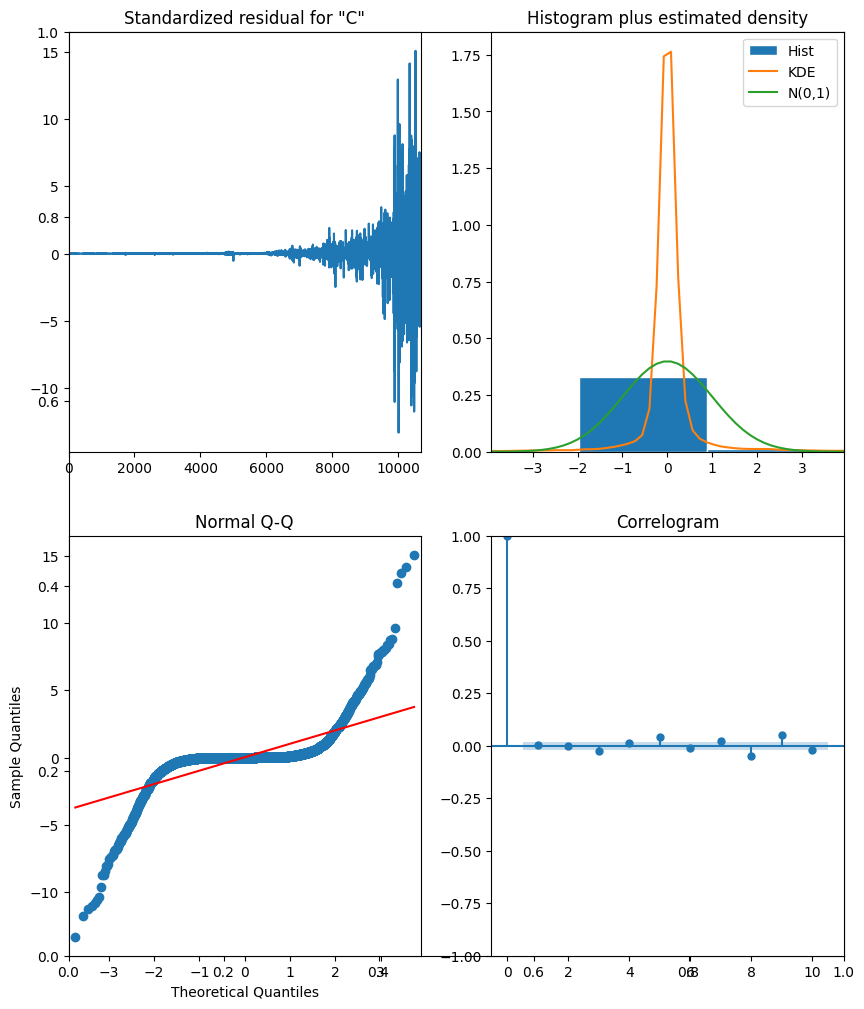

In [15]:
# Using the plot_diagnostics method, I'll check the model residuals
fig, ax = plt.subplots(figsize=(10, 12))
results.plot_diagnostics(fig=fig);


In [16]:
"""""Model has some issues with non-normality and heteroskedasticity
Common in financial time series
While not perfect, correlogram suggests decent model fit
"""

'""Model has some issues with non-normality and heteroskedasticity\nCommon in financial time series\nWhile not perfect, correlogram suggests decent model fit\n'

In [ ]:

# Define window size (Expanding or Rolling)
window_size = len(y_train)  
y_pred_wfv = []

# Initialize the ARIMA model once
history = list(y_train['Close'])  
# Step size of 5 for efficiency
for i in range(0, len(y_test), 5):  
    if i + 5 > len(y_test):  
        steps = len(y_test) - i
    else:
        steps = 5
    
    # Append only the required portion
    history.extend(y_test['Close'].iloc[i:i+steps])  
    
    # Fit only on recent data (Rolling Window)
    model = ARIMA(history[-window_size:], order=(1,1,1)).fit()
    
    # Predict next 5 steps
    next_pred = model.forecast(steps=steps)
    y_pred_wfv.extend(next_pred)

# Convert list to Pandas Series
y_pred_wfv = pd.Series(y_pred_wfv, index=y_test.index)

# Compute MAE
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))


Test MAE (walk forward validation): 1.77


In [ ]:
print(len(y_test), len(y_pred_wfv))

1070 1070


In [ ]:
y_test = y_test.squeeze()
print(type(y_test))
print(type(y_pred_wfv))


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
df_predictions = pd.DataFrame({"y_test":y_test, "y_pred_wfv":y_pred_wfv})
fig = px.line(df_predictions, labels = {"value": "Stock Price"}) 
fig.show()